In [1]:
"""
* CS-370 | Current/ Emerging Trends in Computer Science - 2024
* Author:              Ryan Hatch
* Date of Development: Mon Nov 24th 06:26:26 2024 
* Last Modified:       Tues Dec 30rd 12:21:21 2024
* Version:             2.2.6
"""

'\n* CS-370 | Current/ Emerging Trends in Computer Science - 2024\n* Author:              Ryan Hatch\n* Date of Development: Mon Nov 24th 06:26:26 2024 \n* Last Modified:       Tues Dec 30rd 12:21:21 2024\n* Version:             2.2.6\n'

# *Treasure Hunt Game Notebook*
<hr>

##### The theme of this project is a popular treasure hunt game in which the player needs to find the treasure before the pirate does. The pirate will try to find the optimal path to the treasure using deep Q-learning. 
<!-- While you will not be developing the entire game, you will write the part of the game that represents the intelligent agent, which is a pirate in this case. -->
##### The first class, `TreasureMaze.py`, represents the environment, which includes a maze object defined as a matrix. The second class, `GameExperience.py`, stores the episodes – that is, all the states that come in between the initial state and the terminal state. This is later used by the agent for learning by experience, called `"exploration"`. 

<!-- This notebook shows how to play a game. Your task is to complete the deep Q-learning implementation for which a skeleton implementation has been provided. The code blocks you will need to complete has #TODO as a header. -->

<!-- First, read and review the next few code and instruction blocks to understand the code that you have been given. -->

In [2]:
from __future__ import print_function
import os, sys, time, datetime, json, random
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD , Adam, RMSprop
from keras.layers.advanced_activations import PReLU
import matplotlib.pyplot as plt
from TreasureMaze import TreasureMaze
from GameExperience import GameExperience
%matplotlib inline

Using TensorFlow backend.


#### The following code block contains an 8x8 matrix that will be used as a maze object:

In [3]:
maze = np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.]
])

#### This helper function allows a visual representation of the maze object:

In [4]:
def show(qmaze):
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row,col in qmaze.visited:
        canvas[row,col] = 0.6
    pirate_row, pirate_col, _ = qmaze.state
    canvas[pirate_row, pirate_col] = 0.3   # pirate cell
    canvas[nrows-1, ncols-1] = 0.9 # treasure cell
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img

##### The pirate agent can move in four directions: left, right, up, and down.

##### While the agent primarily learns by experience through exploitation, often, the agent can choose to explore the environment to find previously undiscovered paths.

##### This is called `exploration` and is defined by epsilon. This value is typically a lower value such as 0.1, which means for every ten attempts, the agent will attempt to learn by experience nine times and will randomly explore a new path one time. You are encouraged to try various values for the exploration factor and see how the algorithm performs.

In [5]:
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3


# Exploration factor
epsilon = 0.1

# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

# Number of possible actions
num_actions = len(actions_dict)


#### The sample code block and output below show creating a maze object and performing one action (DOWN), which returns the reward. The resulting updated environment is visualized.

reward= -0.04


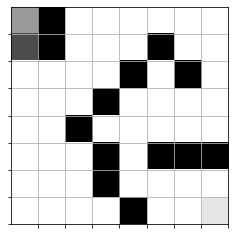

In [6]:
qmaze = TreasureMaze(maze)
canvas, reward, game_over = qmaze.act(DOWN)
print("reward=", reward)
show(qmaze)

# # qmaze = TreasureMaze(maze)
# # envstate, reward, game_status = qmaze.act(DOWN)
# # print("reward=", reward)
# # show(qmaze)

# qmaze = TreasureMaze(maze)
# canvas, reward, game_over = qmaze.act(DOWN)
# print("reward=", reward)
# show(qmaze)

#### This function simulates a full game based on the provided trained model. The other parameters include the TreasureMaze object and the starting position of the pirate.

In [7]:
def play_game(model, qmaze, pirate_cell):
    qmaze.reset(pirate_cell)
    envstate = qmaze.observe()
    while True:
        prev_envstate = envstate
        # get next action
        q = model.predict(prev_envstate)
        action = np.argmax(q[0])

        # apply action, get rewards and new state
        envstate, reward, game_status = qmaze.act(action)
        if game_status == 'win':
            return True
        elif game_status == 'lose':
            return False

# # def play_game(model, qmaze, pirate_cell):
# #     qmaze.reset(pirate_cell)
# #     envstate = qmaze.observe()
# #     while True:
# #         prev_envstate = envstate
# #         # get next action
# #         q = model.predict(prev_envstate)
# #         action = np.argmax(q[0])

# #         # apply action, get rewards and new state
# #         envstate, reward, game_status = qmaze.act(action)
# #         if game_status == 'win':
# #             return True
# #         elif game_status == 'lose':
# #             return False

# def play_game(model, qmaze, pirate_cell):
#     qmaze.reset(pirate_cell)
#     envstate = qmaze.observe()
#     while True:
#         prev_envstate = envstate
#         # get next action
#         q = model.predict(prev_envstate)
#         action = np.argmax(q[0])

#         # apply action, get rewards and new state
#         envstate, reward, game_status = qmaze.act(action)
#         if game_status == 'win':
#             return True
#         elif game_status == 'lose':
#             return False

#### This function helps you to determine whether the pirate can win any game at all. If your maze is not well designed, the pirate may not win any game at all. 
#### In this case, your training would not yield any result. 
<!-- The provided maze in this notebook ensures that there is a path to win and you can run this method to check. -->

In [8]:
def completion_check(model, qmaze):
    for cell in qmaze.free_cells:
        if not qmaze.valid_actions(cell):
            return False
        if not play_game(model, qmaze, cell):
            return False
    return True

In [9]:
"""
Builds a neural network model using Keras Sequential API.

Parameters:
- maze: The maze environment as a NumPy array.

Returns:
- model: Compiled Keras model.
"""

'\nBuilds a neural network model using Keras Sequential API.\n\nParameters:\n- maze: The maze environment as a NumPy array.\n\nReturns:\n- model: Compiled Keras model.\n'

In [10]:
def build_model(maze):
    model = Sequential()
    model.add(Dense(maze.size, input_shape=(maze.size,)))
    model.add(PReLU())
    model.add(Dense(maze.size))
    model.add(PReLU())
    model.add(Dense(num_actions))
    model.compile(optimizer='adam', loss='mse')
    return model

<!-- ## TODO: Complete the Q-Training Algorithm Code Block -->

#### The Q-learning algorithm is a model-free, reinforcement learning algorithm. The goal of Q-learning is to learn a policy, which tells an agent what action to take under what circumstances. It does not require a model of the environment and can handle problems with stochastic transitions and rewards without requiring adaptations. 

#### *The goal of this model is to be trained and then used to find the treasure in the maze.*

<!-- 
#### This is your deep Q-learning implementation. The goal of your deep Q-learning implementation is to find the best possible navigation sequence that results in reaching the treasure cell while maximizing the reward. In your implementation, you need to determine the optimal number of epochs to achieve a 100% win rate.

#### You will need to complete the section starting with #pseudocode. The pseudocode has been included for you. -->

In [11]:
"""
Trains the pirate agent using Deep Q-Learning to navigate the maze and find the treasure.

Parameters:
- model: The neural network model to be trained.
- maze: The maze environment as a NumPy array.
- **opt: Optional parameters including:
    - n_epoch: Number of training epochs (default: 15000)
    - max_memory: Maximum number of episodes to store in memory (default: 1000)
    - data_size: Number of samples to train on per epoch (default: 50)
    - epsilon: Initial exploration factor (default: 0.1)

Returns:
- seconds: Total training time in seconds.
"""

'\nTrains the pirate agent using Deep Q-Learning to navigate the maze and find the treasure.\n\nParameters:\n- model: The neural network model to be trained.\n- maze: The maze environment as a NumPy array.\n- **opt: Optional parameters including:\n    - n_epoch: Number of training epochs (default: 15000)\n    - max_memory: Maximum number of episodes to store in memory (default: 1000)\n    - data_size: Number of samples to train on per epoch (default: 50)\n    - epsilon: Initial exploration factor (default: 0.1)\n\nReturns:\n- seconds: Total training time in seconds.\n'

In [12]:
def qtrain(model, maze, **opt):

    # exploration factor
    global epsilon 

    # number of epochs
    n_epoch = opt.get('n_epoch', 15000)

    # maximum memory to store episodes
    max_memory = opt.get('max_memory', 1000)

    # maximum data size for training
    data_size = opt.get('data_size', 50)

    # start time
    start_time = datetime.datetime.now()

    # Construct environment/game from numpy array: maze (see above)
    qmaze = TreasureMaze(maze)

    # Initialize experience replay object
    experience = GameExperience(model, max_memory=max_memory)
    
    win_history = []   # history of win/lose game
    hsize = qmaze.maze.size//2   # history window size
    win_rate = 0.0
    
    # **** Q-learning algorithm ****
    for epoch in range(n_epoch):
        loss = 0.0       
        # Select random agent cell
        agent_cell = random.choice(qmaze.free_cells)
        # Set agent in random cell
        qmaze.reset(agent_cell)
        envstate = qmaze.observe()
        n_episodes = 0
        
        while qmaze.game_status() == 'not_over':
            valid_actions = qmaze.valid_actions()
            if not valid_actions: break
            previous_envstate = envstate
        
            # Retrieve next random action
            if np.random.rand() < epsilon:
                action = random.choice(valid_actions)
            else:
                action = np.argmax(experience.predict(previous_envstate))
        
            # Agent takes action
            envstate, reward, game_status = qmaze.act(action)
            
            # Pirate won
            if game_status == 'win':
                win_history.append(1)
                win_rate = sum(win_history) / len(win_history)
                break
            # Pirate lost
            elif game_status == 'lose':
                win_history.append(0)
                win_rate = sum(win_history) / len(win_history)
                break
            # Continues game if pirate has not won or lost yet
        
            # Stores episode in experience replay
            episode = [previous_envstate, action, reward, envstate, game_status]
            experience.remember(episode)
            # Increment the episode count 
            n_episodes += 1
            
            # Train neural network model and evaluate loss
            inputs,targets = experience.get_data(data_size=data_size)
            history = model.fit(inputs, targets, epochs=8, batch_size=16, verbose=0)
            loss = model.evaluate(inputs, targets, verbose = 0)
        
        # Check if the win rate is above threshold
        if win_rate > epsilon:
            print('Win rate above threshold')
            if completion_check(model, qmaze) == True:
                print('Model passed completion check')
    
    #Print the epoch, loss, episodes, win count, and win rate for each epoch
        dt = datetime.datetime.now() - start_time
        t = format_time(dt.total_seconds())
        template = "Epoch: {:03d}/{:d} | Loss: {:.4f} | Episodes: {:d} | Win count: {:d} | Win rate: {:.3f} | time: {}"
        print(template.format(epoch, n_epoch-1, loss, n_episodes, sum(win_history), win_rate, t))
        # We simply check if training has exhausted all free cells and if in all
        # cases the agent won.
        if win_rate > 0.9 : epsilon = 0.05
        if sum(win_history[-hsize:]) == hsize and completion_check(model, qmaze):
            print("Reached 100%% win rate at epoch: %d" % (epoch,))
            break
    
    
    # Determine the total time for training
    dt = datetime.datetime.now() - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)

    print("n_epoch: %d, max_mem: %d, data: %d, time: %s" % (epoch, max_memory, data_size, t))
    return seconds

# This is a small utility for printing readable time strings:
def format_time(seconds):
    if seconds < 400:
        s = float(seconds)
        return "%.1f seconds" % (s,)
    elif seconds < 4000:
        m = seconds / 60.0
        return "%.2f minutes" % (m,)
    else:
        h = seconds / 3600.0
        return "%.2f hours" % (h,)

In [13]:
# def qtrain(model, maze, **opt):
#     """
#     Trains the pirate agent using Deep Q-Learning to navigate the maze and find the treasure.
    
#     Parameters:
#     - model: The neural network model to be trained.
#     - maze: The maze environment as a NumPy array.
#     - **opt: Optional parameters including:
#         - n_epoch: Number of training epochs (default: 15000)
#         - max_memory: Maximum number of episodes to store in memory (default: 1000)
#         - data_size: Number of samples to train on per epoch (default: 50)
#         - epsilon: Initial exploration factor (default: 0.1)
    
#     Returns:
#     - seconds: Total training time in seconds.
#     """
    
#     # Define the format_time function within qtrain
#     def format_time(seconds):
#         """
#         Converts a time duration from seconds to a human-readable string.

#         Parameters:
#         - seconds (float): Time duration in seconds.

#         Returns:
#         - str: Human-readable time string.
#         """
#         if seconds < 60:
#             return f"{seconds:.1f} seconds"
#         elif seconds < 3600:
#             minutes = seconds / 60
#             return f"{minutes:.2f} minutes"
#         else:
#             hours = seconds / 3600
#             return f"{hours:.2f} hours"

#     # Retrieve optional parameters or set to default values
#     n_epoch = opt.get('n_epoch', 15000)          # Total number of training epochs
#     max_memory = opt.get('max_memory', 1000)     # Maximum episodes to store in memory
#     data_size = opt.get('data_size', 50)         # Number of training samples per epoch
#     epsilon = opt.get('epsilon', 0.1)            # Initial exploration factor
    
#     # Record the start time to monitor training duration
#     start_time = datetime.datetime.now()
    
#     #* Initialize the maze environment
#     qmaze = TreasureMaze(maze)
    
#     # Initialize the experience replay memory
#     experience = GameExperience(model, max_memory=max_memory)
    
#     #* Initialize variables to track training progress
#     win_history = []                  # History of game outcomes (1 for win, 0 for loss)
#     hsize = qmaze.maze.size // 2      # Window size for calculating win rate
#     win_rate = 0.0                    # Current win rate
    
#     # Iterate over each epoch
#     for epoch in range(n_epoch):
#         # Randomly select a free cell as the pirate's starting position
#         agent_cell = random.choice(qmaze.free_cells)
        
#         # Reset the maze environment with the pirate at the selected starting position
#         qmaze.reset(agent_cell)
        
#         # Observe the current state of the environment
#         envstate = qmaze.observe()
        
#         # Initialize variables for the current episode
#         game_over = False               # Flag to determine if the game has ended
#         n_episodes = 0                  # Number of steps taken in the current epoch
#         win = False                     # Flag to indicate if the current episode is a win
        
#         # Continue interacting with the environment until the game is over
#         while not game_over:
#             # Store the previous state for experience replay
#             prev_envstate = envstate.copy()
            
#             # Decide whether to explore or exploit based on the epsilon-greedy strategy
#             if random.random() < epsilon:
#                 #* Exploration: choose a random valid action
#                 valid_actions = qmaze.valid_actions()
#                 if valid_actions:
#                     action = random.choice(valid_actions)
#                 else:
#                     # No valid actions available; the game is blocked
#                     action = None
#             else:
#                 #* Exploitation: choose the best action based on current Q-values
#                 q_values = experience.predict(prev_envstate)
                
#                 # Retrieve valid actions to mask invalid ones
#                 valid_actions = qmaze.valid_actions()
#                 if valid_actions:
#                     # Initialize Q-values for all actions as -infinity
#                     q_values_invalid = np.full(num_actions, -np.inf)
#                     # Assign actual Q-values to valid actions
#                     q_values_invalid[valid_actions] = q_values[valid_actions]
#                     # Select the action with the highest Q-value among valid actions
#                     action = np.argmax(q_values_invalid)
#                 else:
#                     # No valid actions available; the game is blocked
#                     action = None
            
#             # Execute the chosen action in the environment
#             if action is not None:
#                 envstate, reward, game_status = qmaze.act(action)
#             else:
#                 # Assign a penalty if the agent is blocked
#                 game_status = 'lose'
#                 reward = -1.0  # Penalty for being blocked
            
#             # Increment the number of steps taken
#             n_episodes += 1
            
#             # Determine if the game has ended
#             game_over = game_status in ['win', 'lose']
            
#             # Store the transition (episode) in experience replay memory
#             episode = [prev_envstate, action, reward, envstate, game_over]
#             experience.remember(episode)
            
#             # Update the win history if the game has ended
#             if game_over:
#                 win = 1 if game_status == 'win' else 0
#                 win_history.append(win)
        
#         # Train the neural network model if enough experiences are available
#         if len(experience.memory) >= data_size:
#             # Retrieve a batch of experiences for training
#             inputs, targets = experience.get_data(data_size=data_size)
            
#             # Train the model on the retrieved batch
#             history = model.fit(inputs, targets, epochs=1, verbose=0)
            
#             # Extract the loss value from the training history
#             loss = history.history['loss'][0]
#         else:
#             # Not enough experiences to train; set loss to None
#             loss = None
        
#         # Calculate the win rate over the most recent hsize episodes
#         if len(win_history) >= hsize:
#             recent_wins = win_history[-hsize:]
#             win_rate = sum(recent_wins) / hsize
#         else:
#             recent_wins = win_history
#             win_rate = sum(recent_wins) / len(recent_wins) if recent_wins else 0.0
        
#         # Calculate the elapsed time since training started
#         dt = datetime.datetime.now() - start_time
#         t = format_time(dt.total_seconds())
        
#         # Prepare the template for epoch information display
#         template = "Epoch: {:05d}/{:d} | Loss: {:.4f} | Episodes: {:d} | Win count: {:d} | Win rate: {:.3f} | Time: {}"
        
#         # Display loss as 0.0 if it's None to avoid formatting issues
#         loss_display = loss if loss is not None else 0.0
        
#         # Print the current epoch's training information
#         print(template.format(epoch+1, n_epoch, loss_display, n_episodes, sum(win_history[-hsize:]), win_rate, t))
        
#         # Gradually decrease the exploration factor epsilon if the win rate is high
#         if win_rate > 0.9:
#             epsilon = max(epsilon * 0.995, 0.05)  # Ensure epsilon doesn't fall below 0.05
        
#         # Early stopping condition: if win rate is 100% over the window and the agent passes the completion check
#         if win_rate == 1.0 and completion_check(model, qmaze):
#             print("Reached 100% win rate at epoch: {}".format(epoch+1))
#             break
    
#     # Calculate the total training time
#     dt = datetime.datetime.now() - start_time
#     seconds = dt.total_seconds()
#     t = format_time(seconds)
    
#     # Print the training summary
#     print("Training completed in epoch: {}, max_memory: {}, data_size: {}, time: {}".format(epoch+1, max_memory, data_size, t))
    
#     return seconds


In [14]:
#* Version 2:

#
#* Version 2.2
# def qtrain(model, maze, **opt):
#     """
#     Trains the pirate agent using Deep Q-Learning to navigate the maze and find the treasure.
    
#     Parameters:
#     - model: The neural network model to be trained.
#     - maze: The maze environment as a NumPy array.
#     - **opt: Optional parameters including:
#         - n_epoch: Number of training epochs (default: 15000)
#         - max_memory: Maximum number of episodes to store in memory (default: 1000)
#         - data_size: Number of samples to train on per epoch (default: 50)
    
#     Returns:
#     - seconds: Total training time in seconds.
#     """
    
#     # Access the global exploration factor
#     global epsilon 
    
#     # Retrieve optional parameters or set to default values
#     n_epoch = opt.get('n_epoch', 15000)          # Total number of training epochs
#     max_memory = opt.get('max_memory', 1000)     # Maximum episodes to store in memory
#     data_size = opt.get('data_size', 50)         # Number of training samples per epoch
    
#     # Record the start time to monitor training duration
#     start_time = datetime.datetime.now()
    
#     # Initialize the maze environment
#     qmaze = TreasureMaze(maze)
    
#     # Initialize the experience replay memory
#     experience = GameExperience(model, max_memory=max_memory)
    
#     # Initialize variables to track training progress
#     win_history = []                  # History of game outcomes (1 for win, 0 for loss)
#     hsize = qmaze.maze.size // 2      # Window size for calculating win rate
#     win_rate = 0.0                     # Current win rate
    
#     # Iterate over each epoch
#     for epoch in range(n_epoch):
#         # Randomly select a free cell as the pirate's starting position
#         agent_cell = random.choice(qmaze.free_cells)
        
#         # Reset the maze environment with the pirate at the selected starting position
#         qmaze.reset(agent_cell)
        
#         # Observe the current state of the environment
#         envstate = qmaze.observe()
        
#         # Initialize variables for the current episode
#         game_over = False               # Flag to determine if the game has ended
#         n_episodes = 0                  # Number of steps taken in the current epoch
#         win = False                     # Flag to indicate if the current episode is a win
        
#         # Continue interacting with the environment until the game is over
#         while not game_over:
#             # Store the previous state for experience replay
#             prev_envstate = envstate.copy()
            
#             # Decide whether to explore or exploit based on epsilon-greedy strategy
#             if random.random() < epsilon:
#                 # Exploration: choose a random valid action
#                 valid_actions = qmaze.valid_actions()
#                 if valid_actions:
#                     action = random.choice(valid_actions)
#                 else:
#                     # No valid actions available; the game is blocked
#                     action = None
#             else:
#                 # Exploitation: choose the best action based on current Q-values
#                 q_values = experience.predict(prev_envstate)
                
#                 # Retrieve valid actions to mask invalid ones
#                 valid_actions = qmaze.valid_actions()
#                 if valid_actions:
#                     # Initialize Q-values for all actions as -infinity
#                     q_values_invalid = np.full(num_actions, -np.inf)
#                     # Assign actual Q-values to valid actions
#                     q_values_invalid[valid_actions] = q_values[valid_actions]
#                     # Select the action with the highest Q-value among valid actions
#                     action = np.argmax(q_values_invalid)
#                 else:
#                     # No valid actions available; the game is blocked
#                     action = None
            
#             # Execute the chosen action in the environment
#             if action is not None:
#                 envstate, reward, game_status = qmaze.act(action)
#             else:
#                 # Assign a penalty if the agent is blocked
#                 game_status = 'lose'
#                 reward = -1.0  # Penalty for being blocked
            
#             # Increment the number of steps taken
#             n_episodes += 1
            
#             # Determine if the game has ended
#             game_over = game_status in ['win', 'lose']
            
#             # Store the transition (episode) in experience replay memory
#             episode = [prev_envstate, action, reward, envstate, game_over]
#             experience.remember(episode)
            
#             # Update the win history if the game has ended
#             if game_over:
#                 win = 1 if game_status == 'win' else 0
#                 win_history.append(win)
        
#         # Train the neural network model if enough experiences are available
#         if len(experience.memory) >= data_size:
#             # Retrieve a batch of experiences for training
#             inputs, targets = experience.get_data(data_size=data_size)
            
#             # Train the model on the retrieved batch
#             history = model.fit(inputs, targets, epochs=1, verbose=0)
            
#             # Extract the loss value from the training history
#             loss = history.history['loss'][0]
#         else:
#             # Not enough experiences to train; set loss to None
#             loss = None
        
#         # Calculate the win rate over the most recent hsize episodes
#         if len(win_history) >= hsize:
#             recent_wins = win_history[-hsize:]
#             win_rate = sum(recent_wins) / hsize
#         else:
#             recent_wins = win_history
#             win_rate = sum(recent_wins) / len(recent_wins) if recent_wins else 0.0
        
#         # Calculate the elapsed time since training started
#         dt = datetime.datetime.now() - start_time
#         t = format_time(dt.total_seconds())
        
#         # Prepare the template for epoch information display
#         template = "Epoch: {:05d}/{:d} | Loss: {:.4f} | Episodes: {:d} | Win count: {:d} | Win rate: {:.3f} | Time: {}"
        
#         # Display loss as 0.0 if it's None to avoid formatting issues
#         loss_display = loss if loss is not None else 0.0
        
#         # Print the current epoch's training information
#         print(template.format(epoch+1, n_epoch, loss_display, n_episodes, sum(win_history[-hsize:]), win_rate, t))
        
#         # Gradually decrease the exploration factor epsilon if the win rate is high
#         if win_rate > 0.9:
#             epsilon = max(epsilon * 0.995, 0.05)  # Ensure epsilon doesn't fall below 0.05
        
#         # Early stopping condition: if win rate is 100% over the window and the agent passes the completion check
#         if win_rate == 1.0 and completion_check(model, qmaze):
#             print("Reached 100% win rate at epoch: {}".format(epoch+1))
#             break
    
#     # Calculate the total training time
#     dt = datetime.datetime.now() - start_time
#     seconds = dt.total_seconds()
#     t = format_time(seconds)
    
#     # Print the training summary
#     print("Training completed in epoch: {}, max_memory: {}, data_size: {}, time: {}".format(epoch+1, max_memory, data_size, t))
    
#     return seconds

### *Test Your Model*

#### Now we will start testing the deep Q-learning implementation. To begin, select `Cell`, then `Run All` from the menu bar. This will run your notebook. As it runs, you should see output begin to appear beneath the next few cells. The code below creates an instance of TreasureMaze.

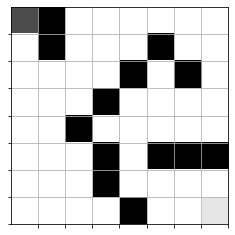

In [15]:
# Initialize the TreasureMaze environment
qmaze = TreasureMaze(maze)
show(qmaze)

# qmaze = TreasureMaze(maze)

#### In the next code block, you will build your model and train it using deep Q-learning. Note: This step takes several minutes to fully run.

In [16]:
# Train the model using deep Q-learning
model = build_model(maze)
qtrain(model, maze, epochs=1000, max_memory=8*maze.size, data_size=32)

# model = build_model(maze)
# training_time = qtrain(model, maze, n_epoch=10000, max_memory=8*maze.size, data_size=32)

# training_time = qtrain(model, maze, n_epoch=10000, max_memory=8*maze.size, data_size=32)

# qtrain(model, maze, epochs=1000, max_memory=8*maze.size, data_size=32)

Epoch: 000/14999 | Loss: 0.0000 | Episodes: 133 | Win count: 0 | Win rate: 0.000 | time: 13.1 seconds
Win rate above threshold
Epoch: 001/14999 | Loss: 0.0005 | Episodes: 77 | Win count: 1 | Win rate: 0.500 | time: 20.2 seconds
Win rate above threshold
Epoch: 002/14999 | Loss: 0.0004 | Episodes: 87 | Win count: 2 | Win rate: 0.667 | time: 28.6 seconds
Win rate above threshold
Epoch: 003/14999 | Loss: 0.0008 | Episodes: 136 | Win count: 2 | Win rate: 0.500 | time: 41.1 seconds
Win rate above threshold
Epoch: 004/14999 | Loss: 0.0001 | Episodes: 145 | Win count: 2 | Win rate: 0.400 | time: 53.8 seconds
Win rate above threshold
Epoch: 005/14999 | Loss: 0.0011 | Episodes: 148 | Win count: 2 | Win rate: 0.333 | time: 68.8 seconds
Win rate above threshold
Epoch: 006/14999 | Loss: 0.0010 | Episodes: 48 | Win count: 3 | Win rate: 0.429 | time: 73.5 seconds
Win rate above threshold
Epoch: 007/14999 | Loss: 0.0010 | Episodes: 8 | Win count: 4 | Win rate: 0.500 | time: 74.5 seconds
Win rate above

Win rate above threshold
Epoch: 065/14999 | Loss: 0.0008 | Episodes: 1 | Win count: 51 | Win rate: 0.773 | time: 367.5 seconds
Win rate above threshold
Epoch: 066/14999 | Loss: 0.0009 | Episodes: 55 | Win count: 52 | Win rate: 0.776 | time: 373.1 seconds
Win rate above threshold
Epoch: 067/14999 | Loss: 0.0011 | Episodes: 16 | Win count: 53 | Win rate: 0.779 | time: 374.9 seconds
Win rate above threshold
Epoch: 068/14999 | Loss: 0.0012 | Episodes: 19 | Win count: 54 | Win rate: 0.783 | time: 376.8 seconds
Win rate above threshold
Epoch: 069/14999 | Loss: 0.0011 | Episodes: 4 | Win count: 55 | Win rate: 0.786 | time: 377.4 seconds
Win rate above threshold
Epoch: 070/14999 | Loss: 0.0010 | Episodes: 21 | Win count: 56 | Win rate: 0.789 | time: 380.0 seconds
Win rate above threshold
Epoch: 071/14999 | Loss: 0.0017 | Episodes: 44 | Win count: 57 | Win rate: 0.792 | time: 384.0 seconds
Win rate above threshold
Epoch: 072/14999 | Loss: 0.0014 | Episodes: 17 | Win count: 58 | Win rate: 0.795 

Win rate above threshold
Epoch: 130/14999 | Loss: 0.0006 | Episodes: 17 | Win count: 115 | Win rate: 0.878 | time: 9.52 minutes
Win rate above threshold
Epoch: 131/14999 | Loss: 0.0013 | Episodes: 30 | Win count: 116 | Win rate: 0.879 | time: 9.57 minutes
Win rate above threshold
Epoch: 132/14999 | Loss: 0.0009 | Episodes: 30 | Win count: 117 | Win rate: 0.880 | time: 9.63 minutes
Win rate above threshold
Epoch: 133/14999 | Loss: 0.0005 | Episodes: 1 | Win count: 118 | Win rate: 0.881 | time: 9.64 minutes
Win rate above threshold
Epoch: 134/14999 | Loss: 0.0006 | Episodes: 61 | Win count: 119 | Win rate: 0.881 | time: 9.73 minutes
Win rate above threshold
Epoch: 135/14999 | Loss: 0.0003 | Episodes: 15 | Win count: 120 | Win rate: 0.882 | time: 9.76 minutes
Win rate above threshold
Epoch: 136/14999 | Loss: 0.0011 | Episodes: 12 | Win count: 121 | Win rate: 0.883 | time: 9.78 minutes
Win rate above threshold
Epoch: 137/14999 | Loss: 0.0006 | Episodes: 46 | Win count: 122 | Win rate: 0.88

Win rate above threshold
Epoch: 194/14999 | Loss: 0.0007 | Episodes: 45 | Win count: 178 | Win rate: 0.913 | time: 13.37 minutes
Win rate above threshold
Epoch: 195/14999 | Loss: 0.0005 | Episodes: 19 | Win count: 179 | Win rate: 0.913 | time: 13.40 minutes
Win rate above threshold
Epoch: 196/14999 | Loss: 0.0011 | Episodes: 19 | Win count: 180 | Win rate: 0.914 | time: 13.44 minutes
Win rate above threshold
Epoch: 197/14999 | Loss: 0.0009 | Episodes: 19 | Win count: 181 | Win rate: 0.914 | time: 13.48 minutes
Win rate above threshold
Epoch: 198/14999 | Loss: 0.0017 | Episodes: 33 | Win count: 182 | Win rate: 0.915 | time: 13.53 minutes
Win rate above threshold
Epoch: 199/14999 | Loss: 0.0015 | Episodes: 11 | Win count: 183 | Win rate: 0.915 | time: 13.55 minutes
Win rate above threshold
Epoch: 200/14999 | Loss: 0.0007 | Episodes: 31 | Win count: 184 | Win rate: 0.915 | time: 13.60 minutes
Win rate above threshold
Epoch: 201/14999 | Loss: 0.0011 | Episodes: 6 | Win count: 185 | Win rat

944.465965

#### This cell will check to see if the model passes the completion check.<br>Note: This could take several minutes.

Model successfully trained to completion.


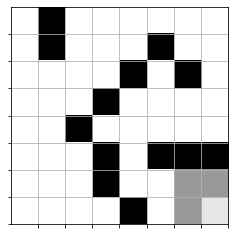

In [17]:
# completion_check(model, qmaze)
completion_check(model, qmaze)
show(qmaze)

# Check if the model passes the completion check
show(qmaze)
if completion_check(model, qmaze):
    print("Model successfully trained to completion.")
else:
    print("Model did not pass the completion check.")

#### This cell will test your model for one game. It will start the pirate at the top-left corner and run play_game. The agent should find a path from the starting position to the target (treasure).<br><br>The treasure is located in the bottom-right corner.

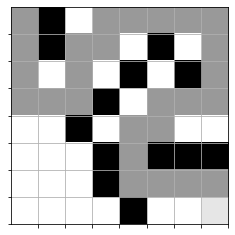

In [18]:
pirate_start = (0, 0)
play_game(model, qmaze, pirate_start)
show(qmaze)

In [23]:
model.save("pirate_model_backup.h5")

<!-- ## Save and Submit Your Work
After you have finished creating the code for your notebook, save your work. Make sure that your notebook contains your name in the filename (e.g. Doe_Jane_ProjectTwo.ipynb). This will help your instructor access and grade your work easily. Download a copy of your IPYNB file and submit it to Brightspace. Refer to the Jupyter Notebook in Apporto Tutorial if you need help with these tasks. -->

<hr>

## *Old versions of the qtrain function that I ended up not using but keeping for reference just incase*

<hr>

In [19]:
#
# Older versions below
#

# def qtrain(model, maze, **opt):
#     """
#     Trains the pirate agent using Deep Q-Learning to navigate the maze and find the treasure.
    
#     Parameters:
#     - model: The neural network model to be trained.
#     - maze: The maze environment as a NumPy array.
#     - **opt: Optional parameters including:
#         - n_epoch: Number of training epochs (default: 15000)
#         - max_memory: Maximum number of episodes to store in memory (default: 1000)
#         - data_size: Number of samples to train on per epoch (default: 50)
    
#     Returns:
#     - seconds: Total training time in seconds.
#     """
    
#     # Access the global exploration factor
#     global epsilon 
    
#     # Retrieve optional parameters or set to default values
#     n_epoch = opt.get('n_epoch', 15000)          # Total number of training epochs
#     max_memory = opt.get('max_memory', 1000)     # Maximum episodes to store in memory
#     data_size = opt.get('data_size', 50)         # Number of training samples per epoch
    
#     # Record the start time to monitor training duration
#     start_time = datetime.datetime.now()
    
#     # Initialize the maze environment
#     qmaze = TreasureMaze(maze)
    
#     # Initialize the experience replay memory
#     experience = GameExperience(model, max_memory=max_memory)
    
#     # Initialize variables to track training progress
#     win_history = []                  # History of game outcomes (1 for win, 0 for loss)
#     hsize = qmaze.maze.size // 2      # Window size for calculating win rate
#     win_rate = 0.0                     # Current win rate
    
#     # Iterate over each epoch
#     for epoch in range(n_epoch):
#         # Randomly select a free cell as the pirate's starting position
#         agent_cell = random.choice(qmaze.free_cells)
        
#         # Reset the maze environment with the pirate at the selected starting position
#         qmaze.reset(agent_cell)
        
#         # Observe the current state of the environment
#         envstate = qmaze.observe()
        
#         # Initialize variables for the current episode
#         game_over = False               # Flag to determine if the game has ended
#         n_episodes = 0                  # Number of steps taken in the current epoch
#         win = False                     # Flag to indicate if the current episode is a win
        
#         # Continue interacting with the environment until the game is over
#         while not game_over:
#             # Store the previous state for experience replay
#             prev_envstate = envstate.copy()
            
#             # Decide whether to explore or exploit based on epsilon-greedy strategy
#             if random.random() < epsilon:
#                 # Exploration: choose a random valid action
#                 valid_actions = qmaze.valid_actions()
#                 if valid_actions:
#                     action = random.choice(valid_actions)
#                 else:
#                     # No valid actions available; the game is blocked
#                     action = None
#             else:
#                 # Exploitation: choose the best action based on current Q-values
#                 q_values = experience.predict(prev_envstate)
                
#                 # Retrieve valid actions to mask invalid ones
#                 valid_actions = qmaze.valid_actions()
#                 if valid_actions:
#                     # Initialize Q-values for all actions as -infinity
#                     q_values_invalid = np.full(num_actions, -np.inf)
#                     # Assign actual Q-values to valid actions
#                     q_values_invalid[valid_actions] = q_values[valid_actions]
#                     # Select the action with the highest Q-value among valid actions
#                     action = np.argmax(q_values_invalid)
#                 else:
#                     # No valid actions available; the game is blocked
#                     action = None
            
#             # Execute the chosen action in the environment
#             if action is not None:
#                 envstate, reward, game_status = qmaze.act(action)
#             else:
#                 # Assign a penalty if the agent is blocked
#                 game_status = 'lose'
#                 reward = -1.0  # Penalty for being blocked
            
#             # Increment the number of steps taken
#             n_episodes += 1
            
#             # Determine if the game has ended
#             game_over = game_status in ['win', 'lose']
            
#             # Store the transition (episode) in experience replay memory
#             episode = [prev_envstate, action, reward, envstate, game_over]
#             experience.remember(episode)
            
#             # Update the win history if the game has ended
#             if game_over:
#                 win = 1 if game_status == 'win' else 0
#                 win_history.append(win)
        
#         # Train the neural network model if enough experiences are available
#         if len(experience.memory) >= data_size:
#             # Retrieve a batch of experiences for training
#             inputs, targets = experience.get_data(data_size=data_size)
            
#             # Train the model on the retrieved batch
#             history = model.fit(inputs, targets, epochs=1, verbose=0)
            
#             # Extract the loss value from the training history
#             loss = history.history['loss'][0]
#         else:
#             # Not enough experiences to train; set loss to None
#             loss = None
        
#         # Calculate the win rate over the most recent hsize episodes
#         if len(win_history) >= hsize:
#             recent_wins = win_history[-hsize:]
#             win_rate = sum(recent_wins) / hsize
#         else:
#             recent_wins = win_history
#             win_rate = sum(recent_wins) / len(recent_wins) if recent_wins else 0.0
        
#         # Calculate the elapsed time since training started
#         dt = datetime.datetime.now() - start_time
#         t = format_time(dt.total_seconds())
        
#         # Prepare the template for epoch information display
#         template = "Epoch: {:05d}/{:d} | Loss: {:.4f} | Episodes: {:d} | Win count: {:d} | Win rate: {:.3f} | Time: {}"
        
#         # Display loss as 0.0 if it's None to avoid formatting issues
#         loss_display = loss if loss is not None else 0.0
        
#         # Print the current epoch's training information
#         print(template.format(epoch+1, n_epoch, loss_display, n_episodes, sum(win_history[-hsize:]), win_rate, t))
        
#         # Gradually decrease the exploration factor epsilon if the win rate is high
#         if win_rate > 0.9:
#             epsilon = max(epsilon * 0.995, 0.05)  # Ensure epsilon doesn't fall below 0.05
        
#         # Early stopping condition: if win rate is 100% over the window and the agent passes the completion check
#         if win_rate == 1.0 and completion_check(model, qmaze):
#             print("Reached 100% win rate at epoch: {}".format(epoch+1))
#             break
    
#     # Calculate the total training time
#     dt = datetime.datetime.now() - start_time
#     seconds = dt.total_seconds()
#     t = format_time(seconds)
    
#     # Print the training summary
#     print("Training completed in epoch: {}, max_memory: {}, data_size: {}, time: {}".format(epoch+1, max_memory, data_size, t))
    
#     return seconds

# # def qtrain(model, maze, **opt):
# #     """
# #     Trains the pirate agent using Deep Q-Learning to navigate the maze and find the treasure.
    
# #     Parameters:
# #     - model: The neural network model to be trained.
# #     - maze: The maze environment as a NumPy array.
# #     - **opt: Optional parameters including:
# #         - n_epoch: Number of training epochs (default: 15000)
# #         - max_memory: Maximum number of episodes to store in memory (default: 1000)
# #         - data_size: Number of samples to train on per epoch (default: 50)
    
# #     Returns:
# #     - seconds: Total training time in seconds.
# #     """
    
# #     # Access the global exploration factor
# #     global epsilon 
    
# #     # Retrieve optional parameters or set to default values
# #     n_epoch = opt.get('n_epoch', 15000)          # Total number of training epochs
# #     max_memory = opt.get('max_memory', 1000)     # Maximum episodes to store in memory
# #     data_size = opt.get('data_size', 50)         # Number of training samples per epoch
    
# #     # Record the start time to monitor training duration
# #     start_time = datetime.datetime.now()
    
# #     # Initialize the maze environment
# #     qmaze = TreasureMaze(maze)
    
# #     # Initialize the experience replay memory
# #     experience = GameExperience(model, max_memory=max_memory)
    
# #     # Initialize variables to track training progress
# #     win_history = []                  # History of game outcomes (1 for win, 0 for loss)
# #     hsize = qmaze.maze.size // 2      # Window size for calculating win rate
# #     win_rate = 0.0                     # Current win rate
    
# #     # Iterate over each epoch
# #     for epoch in range(n_epoch):
# #         # Randomly select a free cell as the pirate's starting position
# #         agent_cell = random.choice(qmaze.free_cells)
        
# #         # Reset the maze environment with the pirate at the selected starting position
# #         qmaze.reset(agent_cell)
        
# #         # Observe the current state of the environment
# #         envstate = qmaze.observe()
        
# #         # Initialize variables for the current episode
# #         game_over = False               # Flag to determine if the game has ended
# #         n_episodes = 0                  # Number of steps taken in the current epoch
# #         win = False                     # Flag to indicate if the current episode is a win
        
# #         # Continue interacting with the environment until the game is over
# #         while not game_over:
# #             prev_envstate = envstate.copy()   # Store the previous state
            
# #             # Decide whether to explore or exploit based on epsilon-greedy strategy
# #             if random.random() < epsilon:
# #                 # Exploration: choose a random valid action
# #                 valid_actions = qmaze.valid_actions()
# #                 if valid_actions:
# #                     action = random.choice(valid_actions)
# #                 else:
# #                     # No valid actions available; the game is blocked
# #                     action = None
# #             else:
# #                 # Exploitation: choose the best action based on current Q-values
# #                 q_values = experience.predict(prev_envstate)
                
# #                 # Mask invalid actions by setting their Q-values to -infinity
# #                 valid_actions = qmaze.valid_actions()
# #                 if valid_actions:
# #                     q_values_invalid = np.full(num_actions, -np.inf)
# #                     q_values_invalid[valid_actions] = q_values[valid_actions]
# #                     action = np.argmax(q_values_invalid)
# #                 else:
# #                     # No valid actions available; the game is blocked
# #                     action = None
            
# #             # Execute the chosen action in the environment
# #             if action is not None:
# #                 envstate, reward, game_status = qmaze.act(action)
# #             else:
# #                 # Assign a penalty if the agent is blocked
# #                 game_status = 'lose'
# #                 reward = -1.0
            
# #             # Increment the number of steps taken
# #             n_episodes += 1
            
# #             # Determine if the game has ended
# #             game_over = game_status in ['win', 'lose']
            
# #             # Store the transition (episode) in experience replay memory
# #             episode = [prev_envstate, action, reward, envstate, game_over]
# #             experience.remember(episode)
            
# #             # Update the win history if the game has ended
# #             if game_over:
# #                 win = 1 if game_status == 'win' else 0
# #                 win_history.append(win)
        
# #         # Train the neural network model if enough experiences are available
# #         if len(experience.memory) >= data_size:
# #             # Retrieve a batch of experiences for training
# #             inputs, targets = experience.get_data(data_size=data_size)
            
# #             # Train the model on the retrieved batch
# #             history = model.fit(inputs, targets, epochs=1, verbose=0)
            
# #             # Extract the loss value from the training history
# #             loss = history.history['loss'][0]
# #         else:
# #             # Not enough experiences to train; set loss to None
# #             loss = None
        
# #         # Calculate the win rate over the most recent hsize episodes
# #         if len(win_history) >= hsize:
# #             recent_wins = win_history[-hsize:]
# #             win_rate = sum(recent_wins) / hsize
# #         else:
# #             recent_wins = win_history
# #             win_rate = sum(recent_wins) / len(recent_wins) if recent_wins else 0.0
        
# #         # Calculate the elapsed time since training started
# #         dt = datetime.datetime.now() - start_time
# #         t = format_time(dt.total_seconds())
        
# #         # Prepare the template for epoch information display
# #         template = "Epoch: {:05d}/{:d} | Loss: {:.4f} | Episodes: {:d} | Win count: {:d} | Win rate: {:.3f} | Time: {}"
        
# #         # Display loss as 0.0 if it's None to avoid formatting issues
# #         loss_display = loss if loss is not None else 0.0
        
# #         # Print the current epoch's training information
# #         print(template.format(epoch+1, n_epoch, loss_display, n_episodes, sum(win_history[-hsize:]), win_rate, t))
        
# #         # Gradually decrease the exploration factor epsilon if the win rate is high
# #         if win_rate > 0.9:
# #             epsilon = max(epsilon * 0.995, 0.05)  # Ensure epsilon doesn't fall below 0.05
        
# #         # Early stopping condition: if win rate is 100% over the window and the agent passes the completion check
# #         if win_rate == 1.0 and completion_check(model, qmaze):
# #             print("Reached 100% win rate at epoch: {}".format(epoch+1))
# #             break
    
# #     # Calculate the total training time
# #     dt = datetime.datetime.now() - start_time
# #     seconds = dt.total_seconds()
# #     t = format_time(seconds)
    
# #     # Print the training summary
# #     print("Training completed in epoch: {}, max_memory: {}, data_size: {}, time: {}".format(epoch+1, max_memory, data_size, t))
    
# #     return seconds

# # #
# # # Original Version that came with the project pre-edits/ added qtrain function to impliment the Deep Q-Learning algorithm
# # #

# # # def qtrain(model, maze, **opt):

# # #     # exploration factor
# # #     global epsilon 

# # #     # number of epochs
# # #     n_epoch = opt.get('n_epoch', 15000)

# # #     # maximum memory to store episodes
# # #     max_memory = opt.get('max_memory', 1000)

# # #     # maximum data size for training
# # #     data_size = opt.get('data_size', 50)

# # #     # start time
# # #     start_time = datetime.datetime.now()

# # #     # Construct environment/game from numpy array: maze (see above)
# # #     qmaze = TreasureMaze(maze)

# # #     # Initialize experience replay object
# # #     experience = GameExperience(model, max_memory=max_memory)
    
# # #     win_history = []   # history of win/lose game
# # #     hsize = qmaze.maze.size//2   # history window size
# # #     win_rate = 0.0
    
# # #     # pseudocode:
# # #     # For each epoch:
# # #     #    Agent_cell = randomly select a free cell
# # #     #    Reset the maze with agent set to above position
# # #     #    Hint: Review the reset method in the TreasureMaze.py class.
# # #     #    envstate = Environment.current_state
# # #     #    Hint: Review the observe method in the TreasureMaze.py class.
# # #     #    While state is not game over:
# # #     #        previous_envstate = envstate
# # #     #        Action = randomly choose action (left, right, up, down) either by exploration or by exploitation
# # #     #        envstate, reward, game_status = qmaze.act(action)
# # #     #    Hint: Review the act method in the TreasureMaze.py class.
# # #     #        episode = [previous_envstate, action, reward, envstate, game_status]
# # #     #        Store episode in Experience replay object
# # #     #    Hint: Review the remember method in the GameExperience.py class.
# # #     #        Train neural network model and evaluate loss
# # #     #    Hint: Call GameExperience.get_data to retrieve training data (input and target) and pass to model.fit method 
# # #     #          to train the model. You can call model.evaluate to determine loss.
# # #     #    If the win rate is above the threshold and your model passes the completion check, that would be your epoch.


# # #     #Print the epoch, loss, episodes, win count, and win rate for each epoch
# # #         dt = datetime.datetime.now() - start_time
# # #         t = format_time(dt.total_seconds())
# # #         template = "Epoch: {:03d}/{:d} | Loss: {:.4f} | Episodes: {:d} | Win count: {:d} | Win rate: {:.3f} | time: {}"
# # #         print(template.format(epoch, n_epoch-1, loss, n_episodes, sum(win_history), win_rate, t))
# # #         # We simply check if training has exhausted all free cells and if in all
# # #         # cases the agent won.
# # #         if win_rate > 0.9 : epsilon = 0.05
# # #         if sum(win_history[-hsize:]) == hsize and completion_check(model, qmaze):
# # #             print("Reached 100%% win rate at epoch: %d" % (epoch,))
# # #             break
    
    
# # #     # Determine the total time for training
# # #     dt = datetime.datetime.now() - start_time
# # #     seconds = dt.total_seconds()
# # #     t = format_time(seconds)

# # #     print("n_epoch: %d, max_mem: %d, data: %d, time: %s" % (epoch, max_memory, data_size, t))
# # #     return seconds

# # # # This is a small utility for printing readable time strings:
# # # def format_time(seconds):
# # #     if seconds < 400:
# # #         s = float(seconds)
# # #         return "%.1f seconds" % (s,)
# # #     elif seconds < 4000:
# # #         m = seconds / 60.0
# # #         return "%.2f minutes" % (m,)
# # #     else:
# # #         h = seconds / 3600.0
# # #         return "%.2f hours" % (h,)